# Data Augmentation

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image

In [2]:
train_dataset = h5py.File('train_catvnoncat.h5', "r")
x_train = np.array(train_dataset["train_set_x"][:], dtype='float32')
y_train = np.array(train_dataset["train_set_y"][:], dtype='float32')

test_dataset = h5py.File('test_catvnoncat.h5', "r")
x_test = np.array(test_dataset["test_set_x"][:], dtype='float32') 
y_test = np.array(test_dataset["test_set_y"][:], dtype='float32')

In [3]:
X_train = x_train 
Y_train = np.reshape(y_train,(-1,1))

X_test = x_test 
Y_test = np.reshape(y_test,(-1,1))

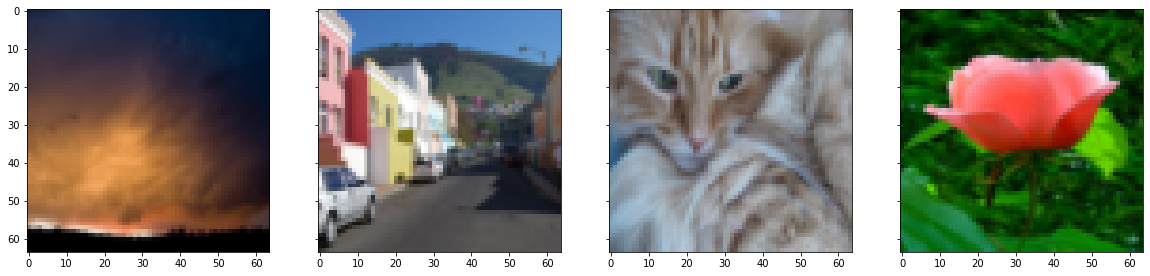

In [4]:
fig, axes = plt.subplots(figsize=(20,5), nrows=1, ncols=4, sharex=True, sharey=True)
axes[0].imshow(X_train[0,:,:,:].astype(dtype='int32'))
axes[1].imshow(X_train[1,:,:,:].astype(dtype='int32'))
axes[2].imshow(X_train[2,:,:,:].astype(dtype='int32'))
axes[3].imshow(X_train[3,:,:,:].astype(dtype='int32'))

(209, 64, 64, 3)
(209, 1)
(209, 64, 64, 3)
(209, 1)
(209, 64, 64, 3)
(209, 1)
(209, 64, 64, 3)
(209, 1)
(209, 64, 64, 3)
(209, 1)
(209, 64, 64, 3)
(209, 1)
(209, 64, 64, 3)
(209, 1)
(209, 64, 64, 3)
(209, 1)
(209, 64, 64, 3)
(209, 1)
(209, 64, 64, 3)
(209, 1)


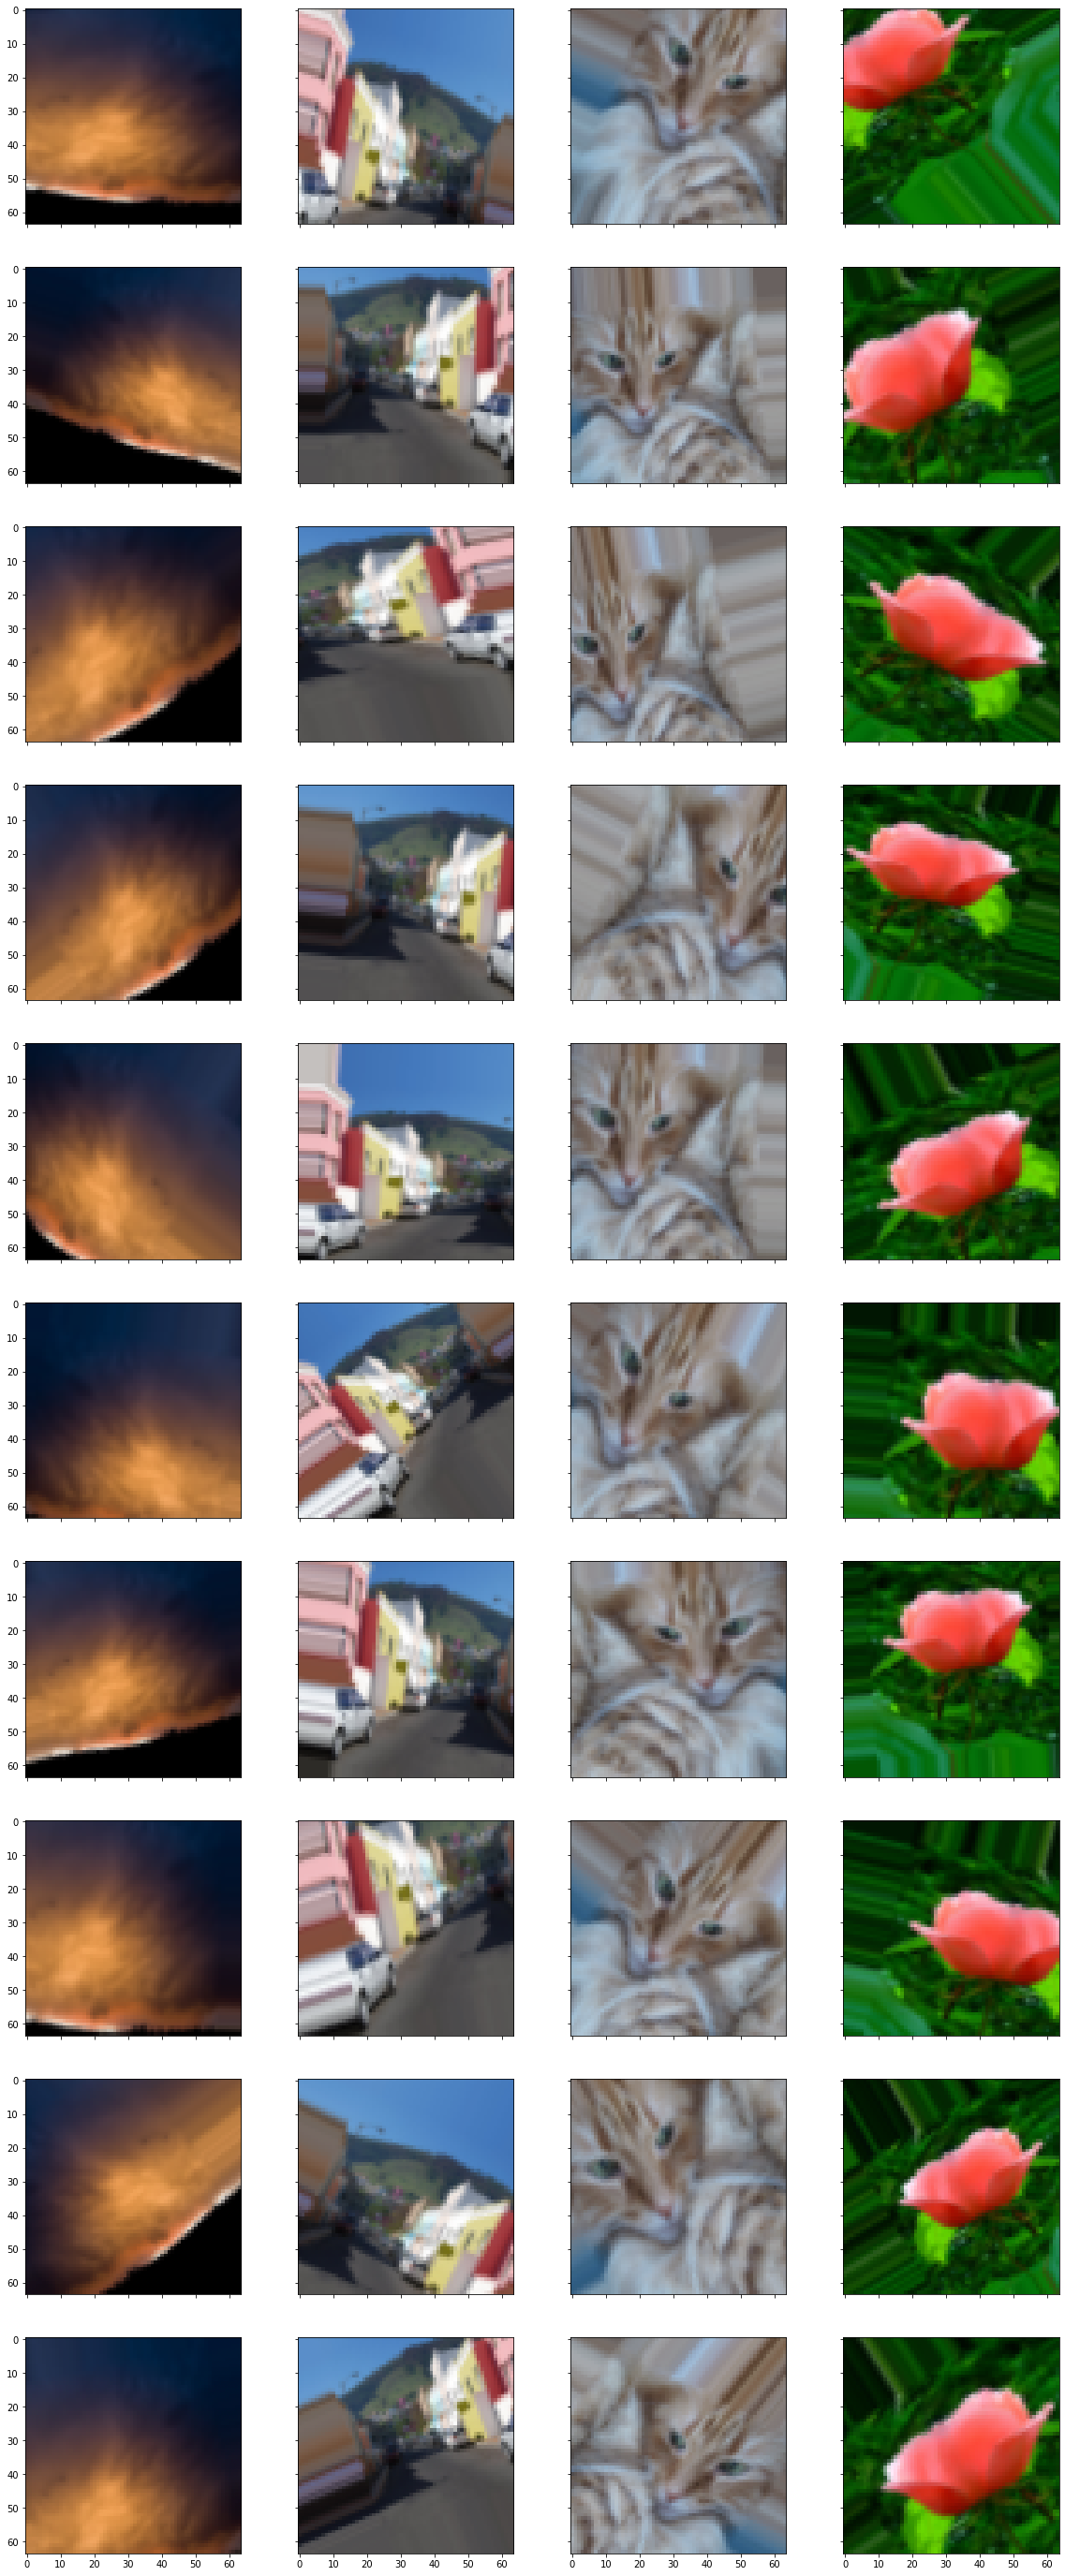

In [5]:
image_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=40,
                                                                       width_shift_range=0.2,
                                                                       height_shift_range=0.2,
                                                                       shear_range=0.2,
                                                                       zoom_range=0.2,
                                                                       fill_mode='nearest',
                                                                       horizontal_flip=True)

fig, axes = plt.subplots(figsize=(20,50), nrows=10, ncols=4, sharex=True, sharey=True)
count = 1
for data in image_data_generator.flow(X_train, Y_train, batch_size=X_train.shape[0], shuffle=False, save_to_dir=None):
    print(data[0].shape)
    print(data[1].shape)
    axes[count-1,0].imshow(data[0][0,:,:,:].astype(dtype='int32'))
    axes[count-1,1].imshow(data[0][1,:,:,:].astype(dtype='int32'))
    axes[count-1,2].imshow(data[0][2,:,:,:].astype(dtype='int32'))
    axes[count-1,3].imshow(data[0][3,:,:,:].astype(dtype='int32'))
    if count==10:
        break
    count = count + 1
plt.show()

In [6]:
class DataAugmentation(tf.keras.Model):
    
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.input_dim = input_shape
        self.output_dim = output_shape
        self.f1 = tf.keras.layers.Lambda(lambda x: x/255.)
        self.f2 = tf.keras.layers.Conv2D(filters=8, 
                                         kernel_size=(3,3), 
                                         strides=(1,1), 
                                         padding='same', 
                                         activation='relu', 
                                         kernel_initializer='glorot_uniform', 
                                         bias_initializer='zeros')
        self.f3 = tf.keras.layers.MaxPooling2D(pool_size=(8,8), 
                                               strides=(8,8), 
                                               padding='same')
        self.f4 = tf.keras.layers.Conv2D(filters=16, 
                                         kernel_size=(3,3), 
                                         strides=(1,1), 
                                         padding='same', 
                                         activation='relu', 
                                         kernel_initializer='glorot_uniform', 
                                         bias_initializer='zeros')
        self.f5 = tf.keras.layers.MaxPooling2D(pool_size=(4,4), 
                                               strides=(4,4), 
                                               padding='same')
        self.f6 = tf.keras.layers.Flatten()
        self.f7 = tf.keras.layers.Dropout(rate=0.5)
        self.f8 = tf.keras.layers.Dense(units=self.output_dim, 
                                        activation='sigmoid', 
                                        kernel_initializer='glorot_uniform', 
                                        bias_initializer='zeros')
            
    def call(self, inputs): 
        a1 = self.f1(inputs)
        a2 = self.f2(a1)
        a3 = self.f3(a2)
        a4 = self.f4(a3)
        a5 = self.f5(a4)
        a6 = self.f6(a5)
        a7 = self.f7(a6)
        y = self.f8(a7)
        return y
    
    def fit(self, x, y, learning_rate=0.01, batch_size=32, epochs=200, beta_1=0.9, beta_2=0.999, epsilon=1e-07, threshold=0.5):
        loss = tf.keras.losses.BinaryCrossentropy()
        metric = tf.keras.metrics.BinaryAccuracy(threshold=threshold) 
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)
        self.compile(loss=loss, metrics=[metric], optimizer=optimizer)
        self.summary(input_dim=self.input_dim)
        image_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=40,
                                                                               width_shift_range=0.2,
                                                                               height_shift_range=0.2,
                                                                               shear_range=0.2,
                                                                               zoom_range=0.2,
                                                                               fill_mode='nearest',
                                                                               horizontal_flip=True)
        steps_per_epoch = x.shape[0]//batch_size+1
        step = 1
        tf.print('Train on {} generated samples'.format(x.shape[0]*epochs))
        for data in image_data_generator.flow(x, y, batch_size=batch_size, shuffle=False, save_to_dir=None):
            x_ = data[0]
            y_ = data[1]
            start_time = tf.timestamp()
            history = super().fit(x=x_, y=y_, batch_size=batch_size, epochs=1, verbose=False)
            now = tf.timestamp()
            time = now - start_time
            if step%steps_per_epoch==0:
                tf.print('Epochs {}/{} - Loss: {} - Metric: {}'.format(step//steps_per_epoch, epochs, history.history['loss'][-1], history.history['binary_accuracy'][-1]))
                tf.print('--- {}s ---'.format(tf.round(1000*time)/1000))
            if step==epochs*steps_per_epoch:
                break
            step = step+1
        
    def summary(self, input_dim):
        x = tf.keras.Input(shape=input_dim)
        y = self(x)
        super().summary()

In [7]:
data_augmentation = DataAugmentation(input_dim=X_train.shape[1:], 
                                     output_dim=Y_train.shape[1])

data_augmentation.fit(x=X_train, y=Y_train)

Model: "data_augmentation"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 8)         224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 16)          1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)          

--- 0.028s ---
Epochs 81/200 - Loss: 0.46938568353652954 - Metric: 0.8823529481887817
--- 0.026s ---
Epochs 82/200 - Loss: 0.3800564408302307 - Metric: 0.8235294222831726
--- 0.028s ---
Epochs 83/200 - Loss: 0.6266099810600281 - Metric: 0.7058823704719543
--- 0.027s ---
Epochs 84/200 - Loss: 0.18284620344638824 - Metric: 0.8823529481887817
--- 0.027s ---
Epochs 85/200 - Loss: 0.29288366436958313 - Metric: 0.8823529481887817
--- 0.028s ---
Epochs 86/200 - Loss: 0.4889582395553589 - Metric: 0.7647058963775635
--- 0.028s ---
Epochs 87/200 - Loss: 0.2924681603908539 - Metric: 0.9411764740943909
--- 0.027s ---
Epochs 88/200 - Loss: 0.39310818910598755 - Metric: 0.8235294222831726
--- 0.028s ---
Epochs 89/200 - Loss: 0.33433276414871216 - Metric: 0.8235294222831726
--- 0.028s ---
Epochs 90/200 - Loss: 0.42766737937927246 - Metric: 0.8823529481887817
--- 0.027s ---
Epochs 91/200 - Loss: 0.38101908564567566 - Metric: 0.7647058963775635
--- 0.028s ---
Epochs 92/200 - Loss: 0.27948346734046936 -

Epochs 176/200 - Loss: 0.4717903137207031 - Metric: 0.8235294222831726
--- 0.027s ---
Epochs 177/200 - Loss: 0.2648012936115265 - Metric: 0.8235294222831726
--- 0.028s ---
Epochs 178/200 - Loss: 0.210806205868721 - Metric: 0.8823529481887817
--- 0.03s ---
Epochs 179/200 - Loss: 0.2180233746767044 - Metric: 0.8235294222831726
--- 0.039s ---
Epochs 180/200 - Loss: 0.251766562461853 - Metric: 0.8823529481887817
--- 0.033s ---
Epochs 181/200 - Loss: 0.4505617022514343 - Metric: 0.8235294222831726
--- 0.041s ---
Epochs 182/200 - Loss: 0.3998245894908905 - Metric: 0.8235294222831726
--- 0.047s ---
Epochs 183/200 - Loss: 0.3407353162765503 - Metric: 0.8235294222831726
--- 0.041s ---
Epochs 184/200 - Loss: 0.47041624784469604 - Metric: 0.8823529481887817
--- 0.036s ---
Epochs 185/200 - Loss: 0.19412918388843536 - Metric: 0.8823529481887817
--- 0.062s ---
Epochs 186/200 - Loss: 0.5599665641784668 - Metric: 0.7647058963775635
--- 0.034s ---
Epochs 187/200 - Loss: 0.22481311857700348 - Metric: 0.

In [8]:
data_augmentation.evaluate(X_train, Y_train)

209/209 [==============================] - 0s 644us/sample - loss: 0.1791 - binary_accuracy: 0.9139


[0.17914496180400893, 0.9138756]

In [9]:
data_augmentation.evaluate(X_test, Y_test)

50/50 [==============================] - 0s 271us/sample - loss: 0.4956 - binary_accuracy: 0.8200


[0.49561293840408327, 0.82]